# Below program is to demostrate Logistic regression to analyze credit card fraud detection

import all necessary package. predominantly we will be using pandas, numpy, sklearn for data processing and matplotlib for plotting the data.

in the below code block helper funcations are defined to plot the data. skip this section if its not usefull

In [32]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

use Pada dataframe to store the CSV data. the data has features which are jumbled up since its synthetic. apart from Time, amount & Class rest are all variables/features we can use it to train our model.

Class 1 is defined as FRAUD.
Class 0 is normal transaction. so we have our lable column as Class.

In [33]:
df = pd.read_csv("creditcard.csv")
print(df.head(3))
y = np.array(df.Class.tolist())     #classes: 1..fraud, 0..no fraud
df = df.drop('Class', 1)
df = df.drop('Time', 1)     # optional
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))    #optionally rescale non-normalized column
X = np.array(df.as_matrix())   # features

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]


lets try to find out how much is the total fraud transaction over all other transactions.

In [34]:
print("Fraction of frauds: {:.5f}".format(np.sum(y)/len(y)))

Fraction of frauds: 0.00173


In [35]:
X, X_val, y, y_val = train_test_split(X, y, test_size = 0.2) 

from sklearn use Logistic Regression package. use KFold to split the dataset and assign 
to respective variables for train and test. 
once done fit the training data and predict
form the confusion matrix and plot it.

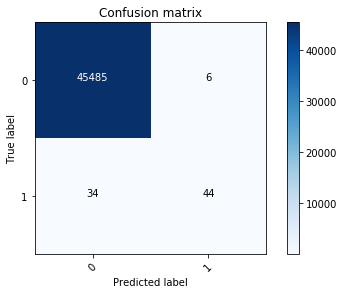

Precision =     0.880
Recall (TPR) =  0.564
Fallout (FPR) = 1.319e-04


In [36]:
lrn = LogisticRegression()

skf = StratifiedKFold(n_splits = 5, shuffle = True)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break

lrn.fit(X_train, y_train)
y_pred = lrn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

In [37]:
def ROC(X, y, c, r):
#makes cross_validation for given parameters c,r. Returns FPR, TPR (averaged)
    dic_weight = {1:len(y)/(r*np.sum(y)), 0:len(y)/(len(y)-r*np.sum(y))} 
    lrn = LogisticRegression(penalty = 'l2', C = c, class_weight = dic_weight)
    
    N = 5      #how much k-fold
    N_iter = 3    #repeat how often (taking the mean)
    mean_tpr = 0.0
    mean_thresh = 0.0
    mean_fpr = np.linspace(0, 1, 50000)
    

    for it in range(N_iter):
        skf = StratifiedKFold(n_splits = N, shuffle = True)
        for train_index, test_index in skf.split(X, y):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]
         
            lrn.fit(X_train, y_train)
            y_prob = lrn.predict_proba(X_test)[:,lrn.classes_[1]]
            
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            mean_tpr += np.interp(mean_fpr, fpr, tpr)
            mean_thresh += np.interp(mean_fpr, fpr, thresholds)
            mean_tpr[0] = 0.0

    mean_tpr /= (N*N_iter)
    mean_thresh /= (N*N_iter)
    mean_tpr[-1] = 1.0
    return mean_fpr, mean_tpr, roc_auc_score(y_test, y_prob), mean_thresh

In [38]:
def plot_roc(X,y, list_par_1, par_1 = 'C', par_2 = 1):

    f = plt.figure(figsize = (12,8));
    for p in list_par_1:
        if par_1 == 'C':
            c = p
            r = par_2
        else:
            r = p
            c = par_2
        list_FP, list_TP, AUC, mean_thresh = ROC(X, y, c, r)      
        plt.plot(list_FP, list_TP, label = 'C = {}, r = {}, TPR(3e-4) = {:.4f}, AUC = {:.4f}'.format(c,r,list_TP[10],AUC));
    plt.legend(title = 'values', loc='lower right')
    plt.xlim(0, 0.001)   #we are only interested in small values of FPR
    plt.ylim(0.5, 0.9)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC detail')
    plt.axvline(3e-4, color='b', linestyle='dashed', linewidth=2)
    plt.show()
    plt.close()

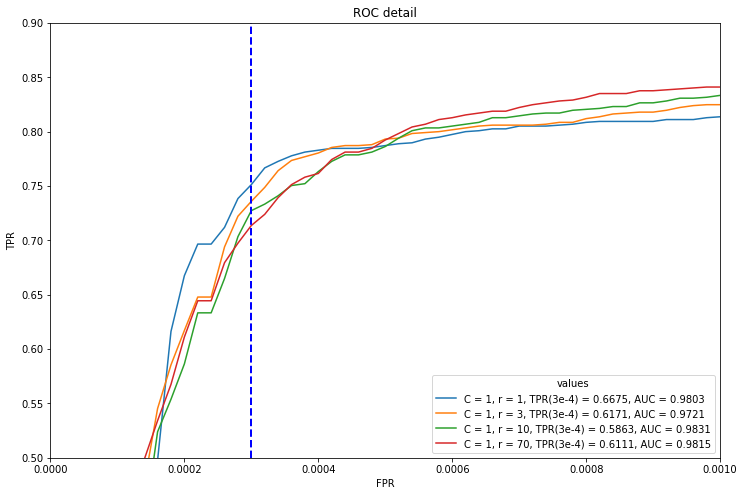

In [39]:
plot_roc(X,y, [1,3,10,70], 'r', 1)

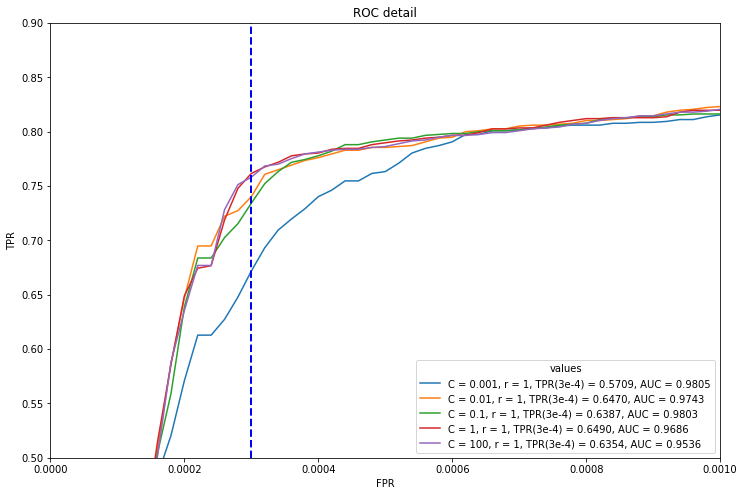

In [40]:
plot_roc(X,y, [0.001, 0.01, 0.1, 1, 100], 'C', 1) 

In [41]:
N = np.arange(10,80,2)     # will define threshold
cm = {}     #will store the confusion matrix for different thresholds
for n in N:
    cm[n] = 0.0
lrn = LogisticRegression(penalty = 'l2', C = 1, class_weight = 'balanced')   #'balanced' corresponds to the case r=1
N_Kfold = 5      #how much k-fold
N_iter = 3   #repeat how often (taking the mean)
for it in range(N_iter):
    skf = StratifiedKFold(n_splits = N_Kfold, shuffle = True)
    for train_index, test_index in skf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        lrn.fit(X_train, y_train)
        y_prob = lrn.predict_proba(X_test)[:,lrn.classes_[1]]
        
        for n in N:
            thresh = 1 - np.power(10.,-(n/10))  #we want thresholds very close to 1
            # generate the prediction from the probabilities y_prob:
            y_pred = np.zeros(len(y_prob))
            for j in range(len(y_prob)):
                if y_prob[j] > thresh:
                    y_pred[j] = 1
    
            B = confusion_matrix(y_test, y_pred)
            #if the classes are mixed up, remedy that:
            if lrn.classes_[0] == 1:
                B = np.array([[B[1,1], B[1,0]], [B[0,1], B[0,0]]])
            cm[n]+=B
#finally, normalize the confusion matrices:
for n in N:
    cm[n] = cm[n]//(N_Kfold*N_iter)

We have now averaged confusion matrices for different thresholds, stored in cm. We extract TPR and FPR from the matrices, and plot them:


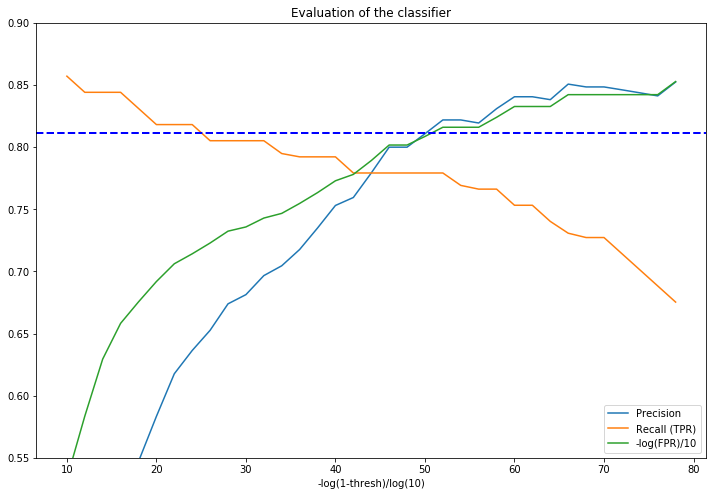

In [42]:
PR = []      #precision
TPR = []
FPR = []
THRESH = N
for n in N:
    pr, tpr, fpr = show_data(cm[n])
    PR.append(pr)
    TPR.append(tpr)
    FPR.append(-np.log(fpr)/10)

g  = plt.figure(figsize = (12,8))   
plt.plot(THRESH, PR, label = 'Precision')
plt.plot(THRESH, TPR, label = 'Recall (TPR)')
plt.plot(THRESH, FPR, label = '-log(FPR)/10')
plt.axhline(-np.log(3e-4)/10, color='b', linestyle='dashed', linewidth=2)
plt.title('Evaluation of the classifier')
plt.legend( loc='lower right')
plt.xlabel('-log(1-thresh)/log(10)')
plt.ylim(0.55,0.9)
plt.show()

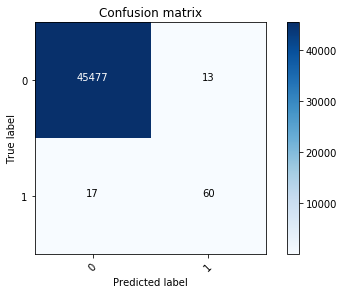

Precision =     0.822
Recall (TPR) =  0.779
Fallout (FPR) = 2.858e-04


In [43]:
i = 0
while FPR[i] < -np.log(3e-4)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
plot_confusion_matrix(A, ['0', '1'])
show_data(A, print_res = 1);

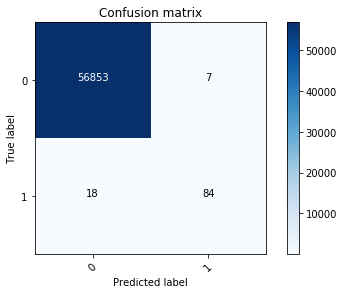

Precision =     0.923
Recall (TPR) =  0.824
Fallout (FPR) = 1.231e-04


In [45]:
lrn.fit(X, y)
y_pred = lrn.predict_proba(X_val)[:,lrn.classes_[1]]
i = 0
while FPR[i] < -np.log(3e-4)/10:
    i+=1
thresh = 1 - 10.**(-THRESH[i]/10)
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(cm, ['0', '1'])
show_data(cm, print_res = 1);